In [7]:
import numpy as np
import gpytorch
from sklearn.utils import shuffle
import torch
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.float64)

In [8]:
def largest_power_of_two(N):
    """
    Find the largest power of two less than or equal to a given integer.
    
    This function takes the training set size N as input and returns the largest power of two less than or equal to N.
    It also returns a list of all powers of two less than or equal to N.
    
    Parameters:
        N (int): A positive integer.
        
    Returns:
        A tuple containing:
            - An integer representing the largest power of two less than or equal to N.
            - A list of all powers of two less than or equal to N.
    """
    n = 0
    while 2**n < N:
        n += 1
    
    powers = []
    for i in range(1,n):
        if 2**i <= N:
            powers.append(2**i)
        else:
            break
    return n - 1,powers


def check_duplicate(array):
    """
    Check if any two elements in an array are equal.
    Used in the check_shuffles() function to make sure all the shuffles are distinct.

    Parameters:
        array: A list or array of numpy ndarrays.

    Returns:
        True if any two elements in the array are equal, False otherwise.
    """
    seen = set()
    for element in array:
        temp_element = tuple(element.flatten())
        if temp_element in seen:
            return True
        seen.add(temp_element)
    return False

def check_shuffles(dataset):
    """
    Check the shuffles used for a given dataset to ensure they are distinct.
    Parameters:
        dataset (str): A string specifying the dataset. Accepted values are "768_benzene" and "151_por".

    Returns:
        True if no duplicate shuffles are found, False otherwise.
    """
    if dataset=="768_benzene":
        input_shuffles=shuffles_x
        output_shuffles=shuffles_output_benzene
    if dataset=="151_por":
        input_shuffles=shuffles_x_por
        output_shuffles=shuffles_output_por
        
    for i in range(3):
        if check_duplicate(output_shuffles[i])== True:
            return False
    if check_duplicate(input_shuffles)==True:
        return False
    return True

In [9]:
#Initialisation for the Benzene dataset with 768 observations

X_tdm_768=np.load("../Binaries/coulomb_matrix_list_tdm.npy")
output_file = np.loadtxt("../InitialData/D_01.dat")
benzene_kernel_lengthscales=[100,200,4900]
largest_two_benzene,train_sizes_benzene=largest_power_of_two(len(X_tdm_768))

#Commented out to not create new shuffles at every code run. Guarantees consistency across multiple calls.
#create_shuffles("768_benzene")

shuffles_x = np.load('../Molecular Shuffles/shuffles_X.npy')
shuffles_output_benzene=[np.load('../Molecular Shuffles/shuffles_Y_1.npy'),np.load('../Molecular Shuffles/shuffles_Y_2.npy'),np.load('../Molecular Shuffles/shuffles_Y_3.npy')
]
if check_shuffles("768_benzene")==False:
    print("Two or more shuffles are identical for the Benzene dataset. Please run create_shuffles function commented again to reshuffle")



#Initialisation for the Porphyrin dataset with 151 observations

x_por=np.load("../Binaries/POR_rep.npy")
por_file = np.loadtxt("../POR/D_01.dat")
por_file=por_file[:151]
largest_two_por,train_sizes_por=largest_power_of_two(len(x_por))

#Commented out to not create new shuffles at every code run. Guarantees consistency across multiple calls.
#create_shuffles("151_por")
shuffles_x_por = np.load('../Molecular Shuffles/shuffles_X_por.npy')
shuffles_output_por=[np.load('../Molecular Shuffles/shuffles_Y_1_por.npy'),np.load('../Molecular Shuffles/shuffles_Y_2_por.npy'),np.load('../Molecular Shuffles/shuffles_Y_3_por.npy')
]
if check_shuffles("151_por")==False:
    print("Two or more shuffles are identical for the Porphyrin dataset. Please run create_shuffles function commented again to reshuffle")


In [10]:
# define the Gaussian process regression model
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [11]:
def initialise(X_train_param,y_train_param,sigma):
    
        
    """
    Initializes the Gaussian Process model with the given training data and kernel hyperparameters.

    Args:
    X_train_param (numpy.ndarray): Input data for training.
    y_train_param (numpy.ndarray): Output data for training.
    sigma (float): Kernel lengthscale to use in GPR algorithm.
    """
    
    likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(10**-9))
    train_x = torch.as_tensor(X_train_param, dtype = torch.float64)
    train_y = torch.as_tensor(y_train_param, dtype = torch.float64)
    model = ExactGPModel(train_x, train_y, likelihood)
        
    hypers = {
            'likelihood.noise_covar.noise': torch.tensor(10**-9),
            'covar_module.base_kernel.lengthscale': torch.tensor(sigma),
            'covar_module.outputscale': torch.tensor(1),
        }
    model.initialize(**hypers)

In [12]:
def GPR(train_x,train_y,x_test,test_y,sigma):
    """
    Performs Gaussian Process Regression (GPR) and calculates the mean absolute error between 
    predicted and actual values.

    Parameters:
        train_x (numpy array): Input data for training, corresponding to an array of Coulomb Matrices.
        train_y (numpy array): Output data for training, corresponding to an array of Coulomb Matrices.
        x_test (numpy array): Array of input testing data.
        test_y (numpy array): Array of output testing data.
        sigma (float): Kernel width.

    Returns:
        The mean absolute error between predicted and actual values.
    """
    
    train_x = torch.as_tensor(train_x, dtype = torch.float64)
    train_y = torch.as_tensor(train_y, dtype = torch.float64)
    test_x = torch.as_tensor(x_test, dtype = torch.float64)
    likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(10**-9))
    model = ExactGPModel(train_x, train_y, likelihood)
    
    hypers = {
        'likelihood.noise_covar.noise': torch.tensor(10**-9),
        'covar_module.base_kernel.lengthscale': torch.tensor(sigma),
        'covar_module.outputscale': torch.tensor(1),
    }
    model.initialize(**hypers)
    model.eval()
    likelihood.eval()
    # Use the model to make predictions on the test_x values
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        
        # Feed the test_x values through the model and likelihood to get predicted distribution over observed values
        observed_pred = likelihood(model(test_x))
    
    mean = observed_pred.mean.detach().numpy()
    return np.mean(np.abs(mean - test_y))

In [13]:


def learning_curve(x_test,y_test,shuffles_component,sigma,dataset):
    """
    Calculates the mean absolute errors of different training sizes
    for a given dataset.

    Parameters:
        x_test (numpy array): Input data for testing.
        y_test (numpy array): Output data for testing.
        shuffles_component (list of numpy arrays): A list of shuffled output data arrays for the training set.
        sigma (float): Kernel width.        
        dataset (str): The name of the dataset to use. Accepted values are "768_benzene" and "151_por".

    Returns:
        mae_list (numpy array): An array of mean absolute errors for each training size in the learning curve.
    """
    if dataset=="768_benzene":
        largest_two=largest_two_benzene
        shuffles_input=shuffles_x
    if dataset=="151_por":
        largest_two=largest_two_por
        shuffles_input=shuffles_x_por
    mae_list=np.zeros(largest_two,dtype=float)
    for j in range(10):
        X_train1,y_train1=shuffles_input[j],shuffles_component[j]
        maes=[]
        for i in (2**p for p in range(1,largest_two+1)):
                temp_mae=GPR(X_train1[0:i],y_train1[0:i],x_test,y_test,sigma)
                maes.append(temp_mae)
        mae_list[:]=np.copy(maes)
    mae_list=mae_list/10
    return mae_list

In [14]:
def lc_plots(dataset):
    '''
    Plots the learning curves for the transition dipole moment components of a given dataset.

    Parameters:                        
        dataset (str): The name of the dataset to use. Accepted values are "768_benzene" and "151_por".
    '''
    if dataset=="768_benzene":
        X_train1, X_test1, y_train1, y_test1 = train_test_split(X_tdm_768, output_file, shuffle=False, train_size=0.8)
        sigmas=benzene_kernel_lengthscales
        shuffles_output=shuffles_output_benzene
        train_sizes=train_sizes_benzene
    if dataset== "151_por":
        X_train1, X_test1, y_train1, y_test1 = train_test_split(x_por, por_file, shuffle=False, train_size=0.8)
        sigmas=[100,100,100]
        shuffles_output=shuffles_output_por
        train_sizes=train_sizes_por
    lc_results=[]
    for i in range (3):
        shuffles_component=shuffles_output[i]
        sigma=sigmas[i]
        y_train_temp1=y_train1[:,i]
        y_test_temp1=y_test1[:,i]
        initialise(X_train1,y_train_temp1,sigma)
        temp_result=learning_curve(X_test1,y_test_temp1,shuffles_component,sigma,dataset)    
        lc_results.append(temp_result)
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('GPR Learning Curves for Transition Dipole Moment Components', fontsize=16)
    for i, ax in enumerate(axs):
        ax.loglog(train_sizes, lc_results[i], marker='.', markersize=10, linewidth=2, color='tab:cyan')
        ax.set_xlabel('Number of Training Samples', fontsize=14)
        ax.set_ylabel('Mean Absolute Error', fontsize=14)
        ax.set_title(f'Component {chr(88+i)}', fontsize=16)

    plt.show()

In [15]:
def GPR_predicted(train_x,train_y,x_test,test_y,sigma):
    """
    Gaussian Process Regression.

    Parameters:
        train_x (numpy array): Input data for training, corresponding to an array of Coulomb Matrices.
        test_x (numpy array): Input data for testing, corresponding to an array of Coulomb Matrices.
        train_y (numpy array): Output data for training, corresponding to an array of scalar values.
        test_y (numpy array): Output data for testing, corresponding to an array of scalar values.
        sigma (float): Kernel width.
        
    Returns:
        mean(numpy array): The values predicted for the given testing data.
    """
    train_x = torch.as_tensor(train_x, dtype = torch.float64)
    train_y = torch.as_tensor(train_y, dtype = torch.float64)
    test_x = torch.as_tensor(x_test, dtype = torch.float64)
    likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(10**-9))
    model = ExactGPModel(train_x, train_y, likelihood)
    
    hypers = {
        'likelihood.noise_covar.noise': torch.tensor(10**-9),
        'covar_module.base_kernel.lengthscale': torch.tensor(sigma),
        'covar_module.outputscale': torch.tensor(1),
    }
    model.initialize(**hypers)
    model.eval()
    likelihood.eval()
    # Use the model to make predictions on the test_x values
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        
        # Feed the test_x values through the model and likelihood to get predicted distribution over observed values
        observed_pred = likelihood(model(test_x))
    
    mean = observed_pred.mean.detach().numpy()
    return mean


def scatter_plot(dataset):
    """
    Plots a scatter plot of predicted vs actual values for the transition dipole moment components using Gaussian Process Regression
    
    Parameters:
        dataset (str): The name of the dataset to use. Accepted values are "768_benzene" and "151_por".
    """
    if dataset=="768_benzene":
        X_train1, X_test1, y_train1, y_test1 = train_test_split(X_tdm_768, output_file, shuffle=False, train_size=0.8)
        sigmas=benzene_kernel_lengthscales
    if dataset=="151_por":
        X_train1, X_test1, y_train1, y_test1 = train_test_split(x_por, por_file, shuffle=False, train_size=0.8)
        sigmas=[100,100,100]

    predicted_values_results=[]
    for i in range (3):
        sigma=sigmas[i]
        y_train1_temp=y_train1[:,i]
        y_test1_temp=y_test1[:,i]
        y_predicted_values=GPR_predicted(X_train1,y_train1_temp,X_test1,y_test1_temp,sigma)
        predicted_values_results.append(y_predicted_values)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Comparison of predicted and actual values of TDM', fontsize=16)
    for i, ax in enumerate(axs):
        ax.plot([y_test1[:,i].min(), y_test1[:,i].max()], [y_test1[:,i].min(), y_test1[:,i].max()], 'k--', lw=2)
        ax.scatter(predicted_values_results[i],y_test1[:,i])
        ax.set_xlabel('Predicted values', fontsize=14)
        ax.set_ylabel('Actual values', fontsize=14)
        ax.set_title(f'Component {chr(88+i)}', fontsize=16)
    plt.subplots_adjust(wspace=0.3)
    plt.show()


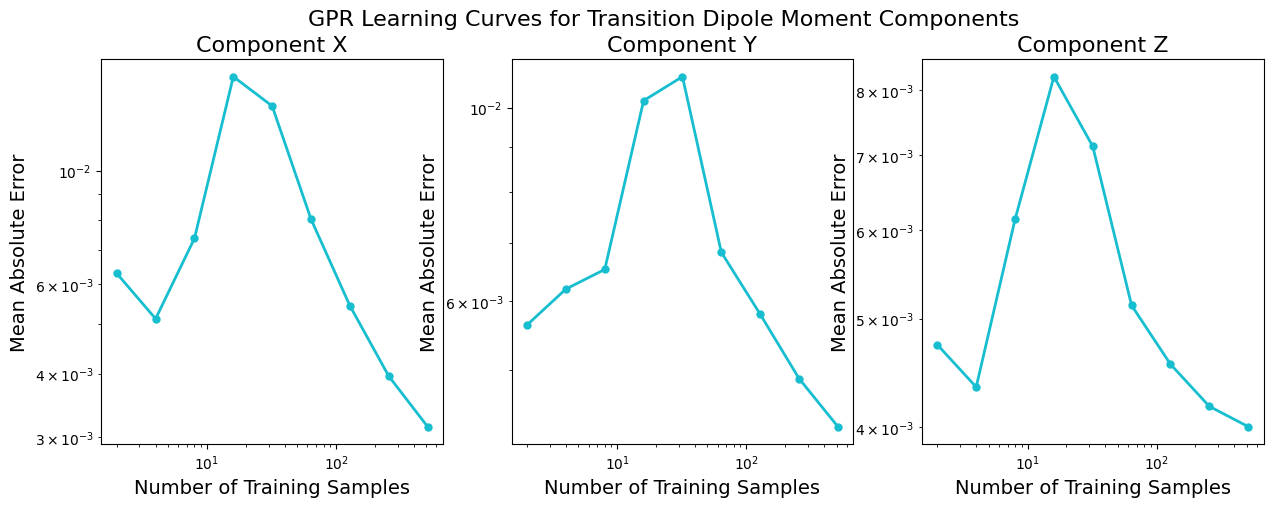

In [16]:
lc_plots("768_benzene")

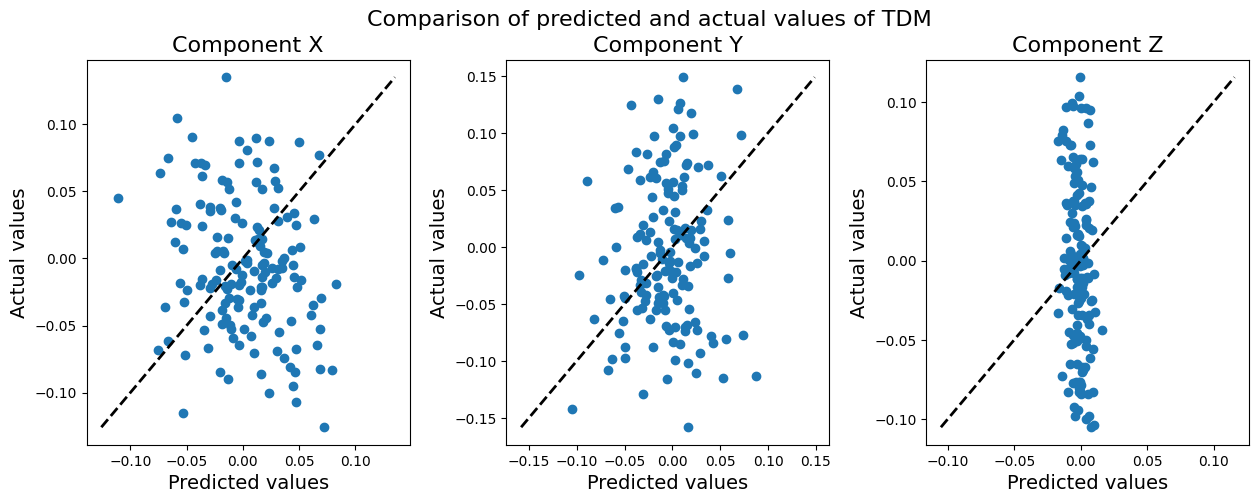

In [17]:
scatter_plot("768_benzene")

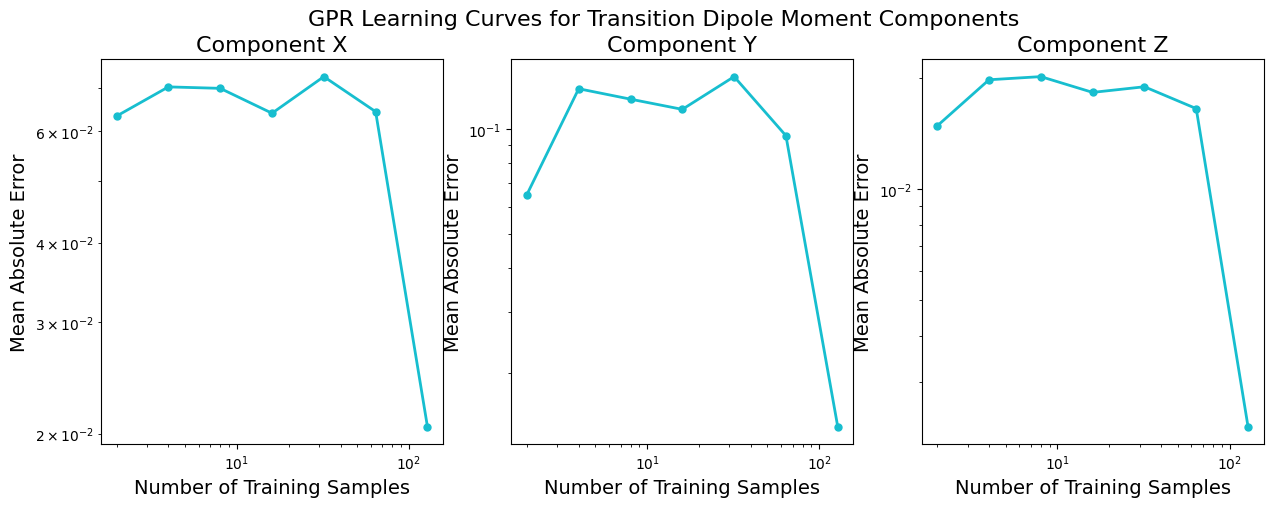

In [18]:
lc_plots("151_por")

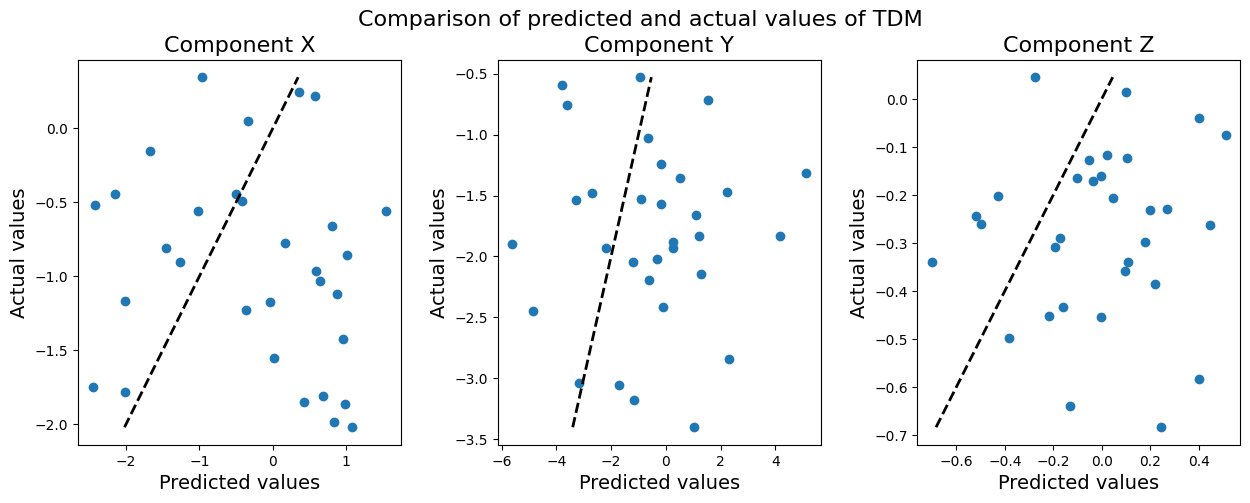

In [19]:
scatter_plot("151_por")